In [1]:
%matplotlib notebook
%matplotlib notebook

from matplotlib import style
style.use('ggplot')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons


import pandas as pd


In [2]:
t = np.arange(0.0, 1.0, 0.002)
#print(t)

# Part 1: A Simple Example
https://home.wlu.edu/~levys/kalman_tutorial/kalman_01.html

<IPython.core.display.Javascript object>


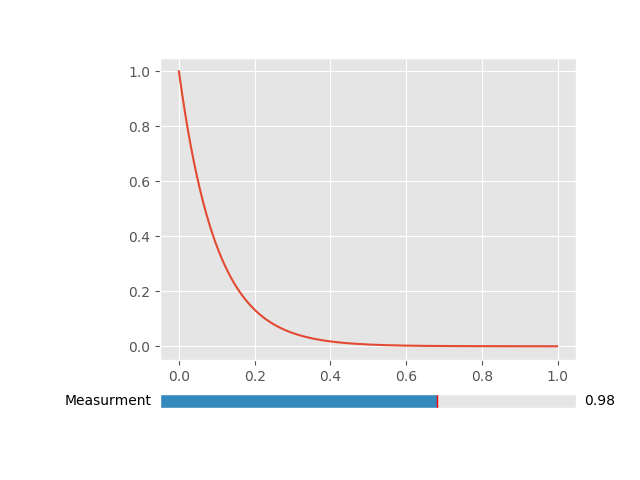

In [3]:
#https://matplotlib.org/examples/widgets/slider_demo.html
t = np.arange(0.0, 1.0, 0.002)
current = []

def calcCurrentMeasurment(gradient):
    measurment = 1
    current[:] = [] 
    for x in np.ndenumerate(t):
        current.append(measurment)
        measurment *= gradient
        
calcCurrentMeasurment(0.98)

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

l, = plt.plot(t, current)

axcur = plt.axes([0.25, 0.15, 0.65, 0.03])
scur = Slider(axcur, 'Measurment', 0.95, 0.995, valinit=0.98)


def update(val):
    calcCurrentMeasurment(scur.val)
    l.set_ydata(current)
    fig.canvas.draw_idle()
        
scur.on_changed(update)
    
        
plt.show()

# Part 2: Dealing with Noise
https://home.wlu.edu/~levys/kalman_tutorial/kalman_02.html

<IPython.core.display.Javascript object>


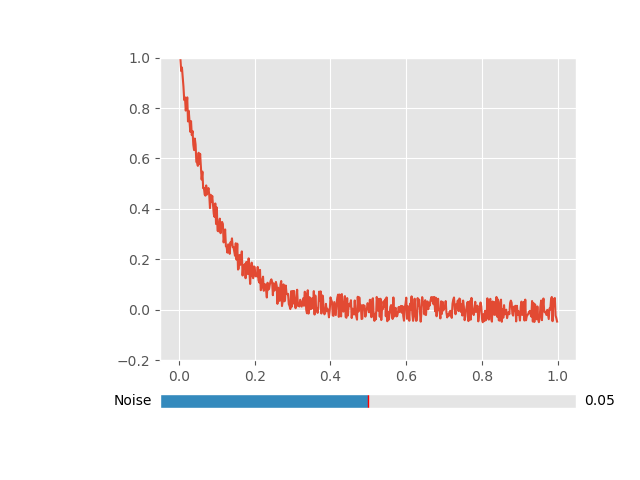

In [4]:
import random
observed = [];

def addNoise(noise):
    observed[:] = [] 
    for x in range(len(current)):
        noisyMeasurment = current[x] + (random.randint(-101,101) / 100) * noise
        observed.append( noisyMeasurment )

addNoise(0.05)
        
fig2, ax2 = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

l2, = plt.plot(t, observed)

axnoise = plt.axes([0.25, 0.15, 0.65, 0.03])
snoise = Slider(axnoise, 'Noise', 0, 0.1, valinit=0.05)  

def updateNoisy(val):
    addNoise(snoise.val)
    l2.set_ydata(observed)
    fig2.canvas.draw_idle()
        
snoise.on_changed(updateNoisy)

ax2.set_ylim([-0.2,1.0])
plt.show()

# Part 3: Putting it Together
https://home.wlu.edu/~levys/kalman_tutorial/kalman_03.html

Two equations describing state

1) current = 0.98 * previous

2) observed = current + noise

$$ x_{k} = ax_{k-1} $$
$$ z_{k} = x_{k} +v_{k} $$

$x_{k}$ = current state at given time
$x$ = current state (measurment)
$x_{k-1}$ = previous state 
$a$ = some constatnt (0.98)

$z_{k}$ = observation at given time
$v_{k}$ = measurment noise

$$ x_{k} = ax_{k-1} + w_{k} $$

$ w_{k} $ = process noise (such as vibration)

# Part 4: State Estimation
https://home.wlu.edu/~levys/kalman_tutorial/kalman_04.html

We can re-write equation to determine current measurement $x_{k}$ from current observation $z_{k}$

$$ z_{k} = x_{k} + v_{k} $$
$$ x_{k} = z_{k} - v_{k} $$

However we dont know what the noise $v_{k}$ is, as its inherently unpredictable.
An estimate can be calculated using the current observation $z_{k}$ and a previous estimate $\hat x_{k1}$ using a gain term $g_{k}$ to trade off between the estimated state or current observation. When the gain is 1, the previous state deosnt matter, when its 0 the observation  has no effect. This is a linear interpolation between to end stops estimate and observation.

<font color='red'> $$\hat x_{k} = \hat x_{k-1} + g_{k}(z_{k} - \hat x_{k-1})$$ </font>



<IPython.core.display.Javascript object>


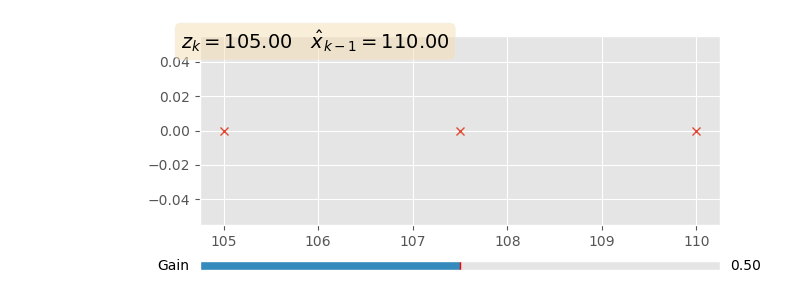

In [5]:
# xk = 0
# xk1 = 110
# zk = 105

datay = [0,0,0]
datax = [0,110,105]

def updateEstimate(gk):
    #xk = xk1 + gk * (zk - xk1);
    #datax[0] = xk1 + gk * (zk - xk1);
    datax[0] = datax[1] + gk * (datax[2] - datax[1]);
    
updateEstimate(0.5)


fig3, ax3 = plt.subplots(1, figsize=(8,3))
plt.subplots_adjust(left=0.25, bottom=0.25)

textstr =  '$  z_{k}=%.2f $   $\hat x_{k-1}=%.2f$' % (datax[2], datax[1])
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax3.text(0.05, 0.5, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

l3, = plt.plot(datax, datay, "x")

axgain = plt.axes([0.25, 0.1, 0.65, 0.03])
sgain = Slider(axgain, 'Gain', 0, 1, valinit=0.5)  



def updateGain(val):
    updateEstimate(sgain.val)
    l3.set_xdata(datax)
    fig3.canvas.draw_idle()
        
sgain.on_changed(updateGain)


plt.show()

# Part 5: Computing the Gain
https://home.wlu.edu/~levys/kalman_tutorial/kalman_05.html

Reminder of the equation for predicting the current state estimate:
<font color='red'> $$\hat x_{k} = \hat x_{k-1} + g_{k}(z_{k} - \hat x_{k-1})$$ </font>

The gain can be calculated indirectly from the noise.  Observation is associated with a particular noise vaule:
$$ z_{k} = x_{k} +v_{k} $$

We don't know the noise level for a given observation, but we know the average. An approximation of noise $ r $ is often provided by the sensor data sheet, which can be used to calculate the gain $g_{k}$ where $p_k$ is a prediction error updated recursively

<font color="red">$$ g_{k} = \dfrac{p_{k-1}}  {(p_{k-1} + r)} $$</font>

If $ p_{k-1} $ was zero, then current gain $ g_{k} $ will be $ \dfrac{0}{0+r} = 0$ and our next estimate will be no different from our current state estimate. This makes sense, as we shouldnt be adjusting our state estimate if our prediction was accurate. 
If $ p_{k-1} $ was 1, then the gain $ g_{k} $ will be $ \dfrac{1}{1+r} = 1$ if $r$ is close to zero. A gain of 1 means the new state estimate will be stongly influency observation $z_{k}$. If the sensor noise $r$ grows large, like when GPS goes bad, the gain can become very small, overcoming the ability to correct for bad predictions.  


<br>
<font color="red">$$ p_{k} = (1-g_{k})p_{k-1} $$</font>

Calculating the predition error $p_{k}$ recursively from the previous prediction $p_{k-1}$ and the gain $g_{k}$. When the gain is 0, there is not update to the prediction error. If the gain is 1, then the prediction error corrosponds to zero.

# Part 6: Prediction and Update

https://home.wlu.edu/~levys/kalman_tutorial/kalman_06.html


### Predict
<br>
1) Project the state ahead (Predict where we are going to be)
<font color="red">$$ \hat x_{k} = a \hat x_{k-1} $$ </font>
2) Project the error covariance (Predict how much error)
<font color="red"> $$ p_{k} = ap_{k-1}a$$ </font> 
<br>
### Update
<br>
1) Calculate the Klaman gain (Moderate the prediction)
<font color="red">$$ g_{k} = \dfrac{p_{k-1}}  {(p_{k-1} + r)} $$</font>
2) Calculate the estimate (New estimate on where we are)
<font color='red'> $$\hat x_{k} = \hat x_{k-1} + g_{k}(z_{k} - \hat x_{k-1})$$ </font>
<br>
3) Update the error covariance (new estimate of error)
<font color="red">$$ p_{k} = (1-g_{k})p_{k-1} $$</font>
<br>
<br>
Gyro Acclerometer example: http://www.ece.montana.edu/seniordesign/archive/SP14/UnderwaterNavigation/kalman_filter.html

# Part 7: Running the Filter

https://home.wlu.edu/~levys/kalman_tutorial/kalman_07.html

In [6]:
# Creates some dummy data, using 'a' as a constant to modify measurments with time
# This could represent measuments from a sensor
def calculateXkMeasurment(a, xk):
    measurment = 100
    xk[:] = [] 
    for i in np.ndenumerate(t):
        xk.append(measurment)
        measurment *= a

# Uses the dummy sensor data, adding noise with magnitude of 'r', which could be
# typical of a some arbitory sensor
def calculateZkObservation(r, xk, zk):
    zk[:] = [] 
    for i in range(len(xk)):
        noisyMeasurment = xk[i] + (random.randint(-101,101) / 100) * r
        zk.append( noisyMeasurment )        

<IPython.core.display.Javascript object>


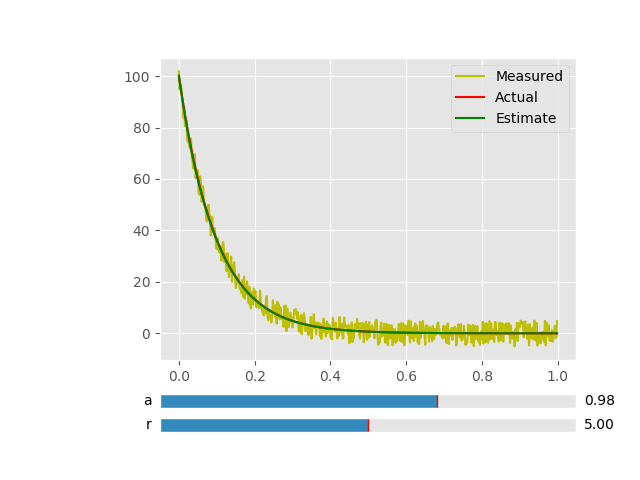

In [7]:

xk_measurment = []
zk_observation = []
pk_predictionError = []
xkhat_estimate = []
gk_gain = []

        
# Perfroms a update and predict as per http://en.wikipedia.org/wiki/Kalman_filter#Update
# Using z observations, a and r, an estimate is made on the actual measuments xk
def runUpdatePredict(a, r):
    
    pk_predictionError[:] = []
    xkhat_estimate[:] = []
    gk_gain[:] = []
    
    xhat = zk_observation[0]
    p = 1

    for i in range(len(xk_measurment)):
        
        z = zk_observation[i] 

        '''PREDICT'''
        xhat = a * xhat                  # Project the state ahead
        p = a * p * a                    # Project the error covariance ahead

        '''UPDATE'''
        g = p / (p + r)                  # Calculate the kalman gain
        xhat = xhat + g * (z-xhat)       # Update the estimate
        p = (1 - g) * p                  # Update the error covariance 

        xkhat_estimate.append(xhat)
        pk_predictionError.append(p)
        gk_gain.append(g)

    



calculateXkMeasurment(0.98, xk_measurment)
calculateZkObservation(5,  xk_measurment, zk_observation)
runUpdatePredict(0.98, 5)


fig4, ax4 = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)


lz, = plt.plot(t, zk_observation, 'y')
lx, = plt.plot(t, xk_measurment, 'r')
lxhat, = plt.plot(t, xkhat_estimate, 'g' )


aaxis = plt.axes([0.25, 0.15, 0.65, 0.03])
aslider = Slider(aaxis, 'a', 0.95, 0.995, valinit=0.98)

raxis = plt.axes([0.25, 0.1, 0.65, 0.03])
rslider = Slider(raxis, 'r',  0, 10, valinit=5)

ax4.legend(['Measured', 'Actual', 'Estimate'])


def updateX(val):
    calculateXkMeasurment(aslider.val, xk_measurment)
    calculateZkObservation(rslider.val, xk_measurment, zk_observation)
    
    runUpdatePredict(aslider.val, rslider.val)
    
    lz.set_ydata(zk_observation)
    lx.set_ydata(xk_measurment)
    lxhat.set_ydata(xkhat_estimate)

    fig4.canvas.draw_idle()
    
def updateZ(val):
    calculateZkObservation(rslider.val,  xk_measurment, zk_observation)
    runUpdatePredict(aslider.val, rslider.val)
    
    lz.set_ydata(zk_observation)
    lx.set_ydata(xk_measurment)
    lxhat.set_ydata(xkhat_estimate)
    fig4.canvas.draw_idle()
    

aslider.on_changed(updateX)
rslider.on_changed(updateZ)
    

plt.show()

# Part 8: A More Realistic Model
https://home.wlu.edu/~levys/kalman_tutorial/kalman_08.html

Recall initial equations:

$$ x_{k} = ax_{k-1} $$
$$ z_{k} = x_{k} +v_{k} $$

where $ x_{k} $ is the current state and $ z_{k} $ is the associated observations.

To account for control input, another veriable can be added $u_{k}$ representing the current value of the control signal. This can also be scaled by a constant amount $b$ to make the following equation:
$$ x_{k} = ax_{k-1} + \color{red}{bu_{k}}  $$
Likewise  our observation is updated to make the following equation
$$ z_{k} = \color{red}{c}x_{k} +v_{k} $$
    

# Part 9: Modifying the Estimates
https://home.wlu.edu/~levys/kalman_tutorial/kalman_09.html

### Predict
<br>
1) Project the state ahead (Predict where we are going to be)
$$ \hat x_{k} = a \hat x_{k-1} + \color{red}{bu_{k}} $$
2) Project the error covariance (Predict how much error)
$$ p_{k} = ap_{k-1}a$$
<br>
### Update
<br>
1) Calculate the Klaman gain (Moderate the prediction)
$$ g_{k} = \dfrac{p_{k-1}\color{red}{c} } {( \color{red}{c} p_{k-1} \color{red}{c} + r)} $$
2) Calculate the estimate (New estimate on where we are)
$$\hat x_{k} = \hat x_{k-1} + g_{k}(z_{k} - \color{red}{c}\hat x_{k-1})$$
<br>
3) Update the error covariance (new estimate of error)
$$ p_{k} = (1-g_{k}\color{red}{c})p_{k-1} $$
<br>
<br>

In [14]:
# Creates some dummy data, using 'a' as a constant to modify measurments with time
# This could represent measuments from a sensor
def calculateXkMeasurment9(a, b, xk):
    x = 100
    u = 0.0
    
    xk[:] = [] 
    for i in range(len(t)):
        u = t[i]
        x = a * x + b * u
        xk.append( x )
        

# Uses the dummy sensor data, adding noise with magnitude of 'r', which could be
# typical of a some arbitory sensor
def calculateZkObservation9(r, c, xk, zk):
    zk[:] = []
    r*=100
    for i in range(len(xk)):
        noisyMeasurment = c * xk[i] + ((random.randint(-101,101) / 100) * r)
        zk.append( noisyMeasurment )       

In [15]:
init_a = 0.98
init_b = 0.5
init_c = 1
init_r = 0.05

<IPython.core.display.Javascript object>


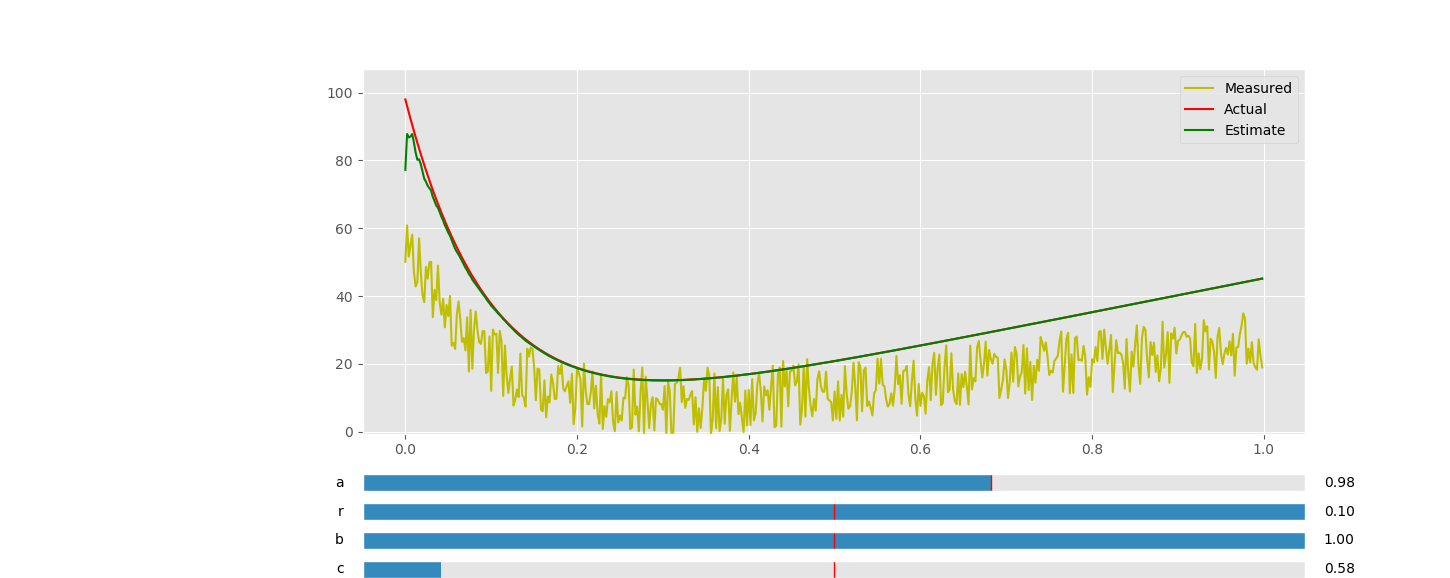

In [18]:
xk9_measurment = []
zk9_observation = []
pk9_predictionError = []
xkhat9_estimate = []
gk9_gain = []

       
# Perfroms a update and predict as per http://en.wikipedia.org/wiki/Kalman_filter#Update
# Using z observations, a and r, an estimate is made on the actual measuments xk
def runUpdatePredict9(a, r, b, c):
    
    pk9_predictionError[:] = []
    xkhat9_estimate[:] = []
    gk9_gain[:] = []
    
    xhat = zk9_observation[0]
    p = 1

    for i in range(len(t)):
        
        # Arbitrary upward control signal
        u = t[i]
        z = zk9_observation[i] 

        '''PREDICT'''
        xhat = a*xhat + b*u              # Project the state ahead
        p = a * p * a                    # Project the error covariance ahead

        '''UPDATE'''
        g = p*c / (c*p*c + r)            # Calculate the kalman gain
        xhat = xhat + g * (z- c*xhat)       # Update the estimate
        p = (1 - g*c) * p                  # Update the error covariance 

        xkhat9_estimate.append(xhat)
        pk9_predictionError.append(p)
        gk9_gain.append(g)

    



calculateXkMeasurment9(init_a, init_b, xk9_measurment)
calculateZkObservation9(init_r, init_c,  xk9_measurment, zk9_observation)
runUpdatePredict9(init_a, init_r, init_b, init_c)


fig5, ax5 = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)


lz9, = plt.plot(t, zk9_observation, 'y')
lx9, = plt.plot(t, xk9_measurment, 'r')
lxhat9, = plt.plot(t, xkhat9_estimate, 'g' )


aaxis9 = plt.axes([0.25, 0.15, 0.65, 0.03])
aslider9 = Slider(aaxis9, 'a', 0.95, 0.995, valinit=init_a)

raxis9 = plt.axes([0.25, 0.1, 0.65, 0.03])
rslider9 = Slider(raxis9, 'r',  0, 0.1, valinit=init_r)

baxis9 = plt.axes([0.25, 0.05, 0.65, 0.03])
bslider9 = Slider(baxis9, 'b',  0, 1, valinit=init_b)

caxis9 = plt.axes([0.25, 0.0, 0.65, 0.03])
cslider9 = Slider(caxis9, 'c',  0.5, 1.5, valinit=init_c)



ax5.legend(['Measured', 'Actual', 'Estimate'])


def update9(val):
    calculateXkMeasurment9(aslider9.val, bslider9.val, xk9_measurment)
    calculateZkObservation9(rslider9.val, cslider9.val, xk9_measurment, zk9_observation)
    
    runUpdatePredict9(aslider9.val, rslider9.val, bslider9.val, cslider9.val)
    
    lz9.set_ydata(zk9_observation)
    lx9.set_ydata(xk9_measurment)
    lxhat9.set_ydata(xkhat9_estimate)

    fig5.canvas.draw_idle()
    
aslider9.on_changed(update9)
rslider9.on_changed(update9)
bslider9.on_changed(update9)
cslider9.on_changed(update9)
    

plt.show()